In [1]:
# ================================
# EUR/JPY Exponential Smoothing (ES) Crossover Backtest
# ================================
# Requirements: pandas, numpy, matplotlib, yfinance (optional for auto-download)
# Works in a single Jupyter cell.

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ---------- Config ----------
PAIR = "EURJPY=X"                   # Yahoo Finance ticker for EUR/JPY
START = "2010-01-01"
END = None                          # None -> up to latest
USE_LOCAL_CSV = False               # Set True to use your own CSV
LOCAL_CSV_PATH = "eurjpy.csv"       # CSV must have columns: Date, Close

# Trading rule:
# "classic" => go long when ES_fast crosses ABOVE ES_slow; short on cross BELOW (trend-following)
# "text_rule" => the exact rule in the prompt (reversed logic)
RULE_STYLE = "classic"  # "classic" or "text_rule"

# Buffer (x) logic: require ES_fast >= ES_slow + X (absolute) or >= ES_slow * (1 + X_PCT) (percent)
USE_ABS_BUFFER = True
X_ABS = 0.05                         # e.g., 0.05 JPY (5 pips ~= 0.05 for JPY quotes with 2 decimals)
USE_PCT_BUFFER = False
X_PCT = 0.0005                       # 5 bps buffer (0.05%)

# Deceleration close on slow ES: close longs if d(ES_slow)/dt < -SLOW_SLOPE_THR; close shorts if > +SLOW_SLOPE_THR
USE_DECELERATION_CLOSE = True
SLOW_SLOPE_THR = 0.02               # per bar absolute slope in price units (tune to your bar freq)
SLOPE_WINDOW = 1                    # first-difference window (1 = adjacent)

# Position sizing & costs
RISK_FREE_ANNUAL = 0.0              # assume 0 for Sharpe (set if desired)
TX_COST_PIPS = 2.0                  # round-trip cost in pips (EUR/JPY: 1 pip = 0.01)
PIP_VALUE = 0.01
SLIPPAGE_PIPS = 0.0

# Grid search space
ALPHAS = np.round(np.linspace(0.02, 0.5, 25), 4)
BETAS  = np.round(np.linspace(0.02, 0.5, 25), 4)
X_ABS_GRID = [0.00, 0.02, 0.05, 0.10]     # 0–10 pips buffer (JPY pip=0.01)
X_PCT_GRID = [0.0]                        # or try [0.0, 0.0003, 0.0007]
SLOW_SLOPE_THR_GRID = [0.0, 0.01, 0.02, 0.04]


# Allow different params for Long and Short?
SEPARATE_LONG_SHORT_PARAMS = False

# Annualization (assume daily bars if using Yahoo daily)
BARS_PER_YEAR = 252

# ---------- Data ----------
def load_prices():
    if USE_LOCAL_CSV:
        df = pd.read_csv(LOCAL_CSV_PATH)
        assert {"Date","Close"}.issubset(df.columns), "CSV must have Date, Close columns"
        df["Date"] = pd.to_datetime(df["Date"])
        df = df.sort_values("Date").set_index("Date")
        df = df.dropna()
        return df[["Close"]].rename(columns={"Close":"price"})
    else:
        try:
            import yfinance as yf
            data = yf.download(PAIR, start=START, end=END, auto_adjust=False, progress=False)
            df = data[["Close"]].dropna().rename(columns={"Close":"price"})
            df.index = pd.to_datetime(df.index)
            return df
        except Exception as e:
            raise RuntimeError(
                f"Could not download {PAIR}. "
                f"Set USE_LOCAL_CSV=True and provide a CSV. Error: {e}"
            )

prices = load_prices()
prices["ret"] = prices["price"].pct_change()  # used for Sharpe; PnL is computed in price space


In [2]:
prices.head(10)

Price,price,ret
Ticker,EURJPY=X,
Date,,
2010-01-01,133.710007,NaN
2010-01-04,133.389999,-0.002393
2010-01-05,131.529999,-0.013944
2010-01-06,133.013000,0.011275
2010-01-07,133.748001,0.005526
2010-01-08,133.490005,-0.001929
2010-01-11,133.619995,0.000974
2010-01-12,131.839996,-0.013321


In [3]:

# ---------- ES & Signals ----------
def exp_smooth(series, alpha):
    # pandas ewm with alpha directly
    return series.ewm(alpha=alpha, adjust=False).mean()

def apply_buffer(fast, slow):
    # Start from plain comparison so we always return a Series
    cond = (fast > slow)
    if USE_ABS_BUFFER:
        cond = fast > (slow + X_ABS)
    if USE_PCT_BUFFER:
        cond = fast > (slow * (1 + X_PCT))
    # Make sure it's a simple bool Series aligned to fast's index
    return _as_bool_mask(cond, fast.index)


def crossover_signals(es_fast, es_slow, rule_style="classic"):
    prior_above = _as_bool_mask(es_fast.shift(1) > es_slow.shift(1), es_fast.index)
    now_above   = _as_bool_mask(es_fast > es_slow, es_fast.index)

    # Optionally apply buffer
    if USE_ABS_BUFFER or USE_PCT_BUFFER:
        now_above = apply_buffer(es_fast, es_slow)

    cross_up   = _as_bool_mask((~prior_above) & (now_above), es_fast.index)
    cross_down = _as_bool_mask((prior_above) & (~now_above), es_fast.index)

    signal = pd.Series(0, index=es_fast.index, dtype=int)
    if rule_style == "classic":
        signal.loc[cross_up] = +1
        signal.loc[cross_down] = -1
    elif rule_style == "text_rule":
        signal.loc[cross_down] = +1
        signal.loc[cross_up]   = -1
    else:
        raise ValueError("rule_style must be 'classic' or 'text_rule'")
    return signal


def build_positions(es_fast, es_slow, rule_style="classic",
                    use_decel_close=True, slow_slope_thr=0.02, slope_window=1):
    # Ensure pure Series
    es_fast = _as_series(es_fast, name="es_fast")
    es_slow = _as_series(es_slow, index=es_fast.index, name="es_slow")

    # Entry signals
    sig = crossover_signals(es_fast, es_slow, rule_style=rule_style)

    # Position state machine
    pos = pd.Series(0, index=sig.index, dtype=int)
    current = 0

    # Precompute slow slope as Series
    slow_diff = _as_series(es_slow.diff(slope_window), index=es_fast.index, name="slow_diff")

    for t in range(len(sig)):
        s = sig.iat[t]
        if s != 0:
            current = s

        if use_decel_close and current != 0:
            # Use iloc to be explicit (Series)
            if current > 0 and slow_diff.iloc[t] < -slow_slope_thr:
                current = 0
            elif current < 0 and slow_diff.iloc[t] > +slow_slope_thr:
                current = 0

        pos.iat[t] = current

    return pos

def _as_bool_mask(obj, index):
    import pandas as pd
    import numpy as np
    if isinstance(obj, pd.DataFrame):
        # If 1 col, take it; if multi-col, reduce rowwise with any()
        obj = obj.iloc[:, 0] if obj.shape[1] == 1 else obj.any(axis=1)
    if isinstance(obj, pd.Series):
        obj = obj.reindex(index).fillna(False).astype(bool)
        return obj
    # numpy or python iterable
    arr = np.asarray(obj).astype(bool).ravel()
    if len(arr) != len(index):
        raise ValueError("Mask length does not match index length.")
    return pd.Series(arr, index=index)

# ---------- Backtest ----------
def backtest(prices, alpha_long, beta_long, alpha_short=None, beta_short=None,
             rule_style="classic", use_decel_close=True,
             slow_slope_thr=SLOW_SLOPE_THR, slope_window=SLOPE_WINDOW,
             tx_cost_pips=TX_COST_PIPS, slippage_pips=SLIPPAGE_PIPS):
    px = _as_series(prices["price"], index=prices.index, name="price")


    if (alpha_short is None) or (beta_short is None):
        alpha_short, beta_short = alpha_long, beta_long

    # Build ES with long/short params (we'll merge positions)
    es_f_long = exp_smooth(px, alpha_long)
    es_s_long = exp_smooth(px, beta_long)

    es_f_short = exp_smooth(px, alpha_short)
    es_s_short = exp_smooth(px, beta_short)

    # Two position streams based on same rule, then combine conservatively:
    pos_long  = build_positions(es_f_long, es_s_long, rule_style, use_decel_close, slow_slope_thr, slope_window)
    pos_short = build_positions(es_f_short, es_s_short, rule_style, use_decel_close, slow_slope_thr, slope_window)

    # Combine: prefer non-zero; if both non-zero and opposite, net to 0
    pos = pos_long.copy()
    dual = (pos_long != 0) & (pos_short != 0) & (pos_long != pos_short)
    pos[dual] = 0
    pos[(pos == 0) & (pos_short != 0)] = pos_short[(pos == 0) & (pos_short != 0)]

    # Trades & transaction costs
    pos_shift = pos.shift(1).fillna(0)
    trade = pos - pos_shift  # +1, -1 = open; -1, +1 (from 1 to 0 or -1 to 0 etc.) = close/flip

    # PnL in price space (position * price change)
    dpx = px.diff().fillna(0.0)
    pnl = pos_shift * dpx

    # Apply costs on changes in position (open/close/flip)
    # Convert pips to price
    round_trip_cost = (tx_cost_pips + slippage_pips) * PIP_VALUE
    cost = (trade != 0).astype(float) * (round_trip_cost / 2.0)  # half spread on entry, half on exit
    pnl_after_cost = pnl - cost

    # Equity curve & metrics
    equity = pnl_after_cost.cumsum()
    ret = pnl_after_cost  # per-bar profit in price units; Sharpe uses pct of price; better: scale by px
    # Convert to returns relative to price level to compute Sharpe
    pct_ret = (pos_shift * dpx / px.shift(1)).fillna(0.0) - (cost / px.shift(1)).fillna(0.0)

    # Sharpe
    mu = pct_ret.mean() * BARS_PER_YEAR
    sigma = pct_ret.std(ddof=0) * np.sqrt(BARS_PER_YEAR)
    sharpe = (mu - RISK_FREE_ANNUAL) / (sigma + 1e-12)

    # Max Drawdown on equity
    roll_max = equity.cummax()
    dd = equity - roll_max
    max_dd = dd.min()

    # Trade stats
    entries = trade[trade != 0]
    # Identify per-trade PnL by marking segments
    trades = []
    cur_dir = 0
    entry_px = None
    for dt, tr in trade.items():
        if tr != 0:
            # If flat -> open
            if cur_dir == 0:
                cur_dir = np.sign(pos.loc[dt])
                entry_px = px.loc[dt]
            else:
                # flip or close: record previous
                exit_px = px.loc[dt]
                trades.append((cur_dir, entry_px, exit_px))
                if np.sign(pos.loc[dt]) == 0:
                    cur_dir = 0
                    entry_px = None
                else:
                    cur_dir = np.sign(pos.loc[dt])
                    entry_px = px.loc[dt]
    # Close any open at end (mark to market last price)
    if cur_dir != 0 and entry_px is not None:
        exit_px = px.iloc[-1]
        trades.append((cur_dir, entry_px, exit_px))

    trade_pnls = []
    for d, ep, xp in trades:
        gross = d * (xp - ep)
        # subtract a round-trip cost
        net = gross - round_trip_cost
        trade_pnls.append(net)

    trade_pnls = np.array(trade_pnls) if len(trade_pnls)>0 else np.array([])
    win_rate = (trade_pnls > 0).mean() if trade_pnls.size else np.nan
    avg_trade = trade_pnls.mean() if trade_pnls.size else np.nan
    num_trades = trade_pnls.size

    res = {
        "alpha_long": alpha_long, "beta_long": beta_long,
        "alpha_short": alpha_short, "beta_short": beta_short,
        "sharpe": sharpe, "max_dd": float(max_dd), "win_rate": win_rate,
        "avg_trade": avg_trade, "num_trades": int(num_trades),
        "equity": equity, "positions": pos, "pnl_after_cost": pnl_after_cost,
    }
    return res
import pandas as pd
import numpy as np

def _as_series(obj, index=None, name=None):
    """Coerce obj to a 1-D pd.Series aligned to `index` (if provided)."""
    if isinstance(obj, pd.DataFrame):
        # If multi-col, take first col
        obj = obj.iloc[:, 0]
    elif not isinstance(obj, pd.Series):
        obj = pd.Series(obj, index=index, name=name)
    if index is not None:
        obj = obj.reindex(index)
    if name is not None:
        obj.name = name
    return obj

def _as_bool_mask(obj, index):
    """(From previous fix) Ensure a 1-D boolean Series aligned to `index`."""
    if isinstance(obj, pd.DataFrame):
        obj = obj.iloc[:, 0] if obj.shape[1] == 1 else obj.any(axis=1)
    if isinstance(obj, pd.Series):
        return obj.reindex(index).fillna(False).astype(bool)
    arr = np.asarray(obj).astype(bool).ravel()
    if len(arr) != len(index):
        raise ValueError("Mask length does not match index length.")
    return pd.Series(arr, index=index)


# ---------- Grid Search ----------
def grid_search(prices, separate_params=False, rule_style="classic",
                use_decel_close=True):
    rows, best = [], None
    for a in ALPHAS:
        for b in BETAS:
            if a >= b: 
                continue
            for xabs in X_ABS_GRID:
                for xpct in X_PCT_GRID:
                    for slope_thr in SLOW_SLOPE_THR_GRID:
                        globals()["USE_ABS_BUFFER"] = (xabs > 0)
                        globals()["X_ABS"] = xabs
                        globals()["USE_PCT_BUFFER"] = (xpct > 0)
                        globals()["X_PCT"] = xpct
                        r = backtest(prices, a, b,
                                     rule_style=rule_style,
                                     use_decel_close=use_decel_close,
                                     slow_slope_thr=slope_thr)
                        rows.append([a,b,None,None,xabs,xpct,slope_thr,
                                     r["sharpe"], r["win_rate"], r["max_dd"],
                                     r["avg_trade"], r["num_trades"]])
                        if (best is None) or (r["sharpe"] > best["sharpe"]):
                            best = r
                            best["grid"] = (a,b,None,None,xabs,xpct,slope_thr)
    cols = ["alpha_long","beta_long","alpha_short","beta_short",
            "x_abs","x_pct","slow_slope_thr",
            "sharpe","win_rate","max_dd","avg_trade","num_trades"]
    out = pd.DataFrame(rows, columns=cols).sort_values("sharpe", ascending=False).reset_index(drop=True)
    return out, best


In [5]:

gs, best = grid_search(prices, separate_params=SEPARATE_LONG_SHORT_PARAMS,
                       rule_style=RULE_STYLE,
                       use_decel_close=USE_DECELERATION_CLOSE,
                       )

display(gs.head(10))
print("Best params (alpha_long, beta_long, alpha_short, beta_short):", best["grid"])
print(f"Best Sharpe: {best['sharpe']:.3f} | Win rate: {best['win_rate']:.2%} | Max DD: {best['max_dd']:.3f} | Trades: {best['num_trades']}")

,alpha_long,beta_long,alpha_short,beta_short,x_abs,x_pct,slow_slope_thr,sharpe,win_rate,max_dd,avg_trade,num_trades
0,0.12,0.46,None,None,0.10,0.0,0.00,0.789255,0.588235,-2.669006,1.762444,17
1,0.12,0.46,None,None,0.10,0.0,0.01,0.771823,0.526316,-2.669006,1.563503,19
2,0.12,0.42,None,None,0.10,0.0,0.00,0.765059,0.571429,-3.278996,1.911683,14
3,0.12,0.44,None,None,0.10,0.0,0.01,0.764499,0.500000,-2.551006,1.513142,18
4,0.12,0.44,None,None,0.10,0.0,0.00,0.763176,0.533333,-3.281006,1.784103,15
5,0.12,0.46,None,None,0.10,0.0,0.02,0.747444,0.476190,-2.902011,1.378978,21
6,0.30,0.46,None,None,0.02,0.0,0.01,0.734655,0.666667,-1.874996,2.001779,9
7,0.12,0.42,None,None,0.10,0.0,0.02,0.724898,0.478261,-2.351010,1.214285,23
8,0.12,0.42,None,None,0.10,0.0,0.01,0.721869,0.444444,-3.414993,1.438031,18
9,0.12,0.46,None,None,0.10,0.0,0.04,0.721431,0.444444,-1.958997,1.090168,27


Best params (alpha_long, beta_long, alpha_short, beta_short): (0.12, 0.46, None, None, 0.1, 0.0, 0.0)
Best Sharpe: 0.789 | Win rate: 58.82% | Max DD: -2.669 | Trades: 17


In [8]:
best['grid']

(0.12, 0.46, None, None, 0.1, 0.0, 0.0)

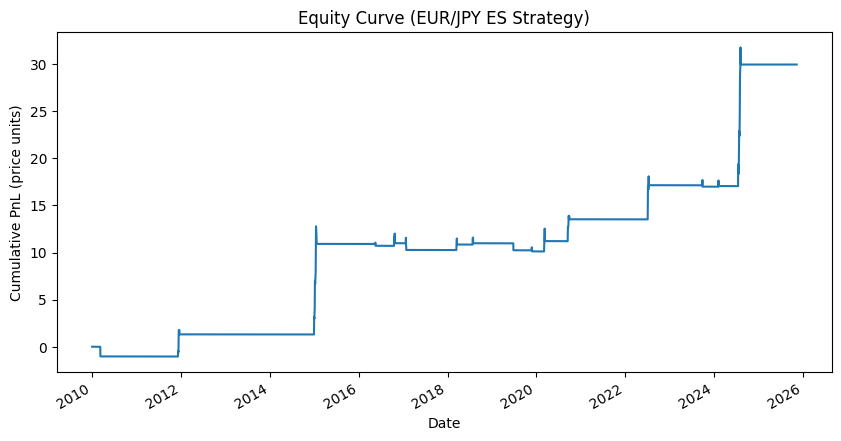

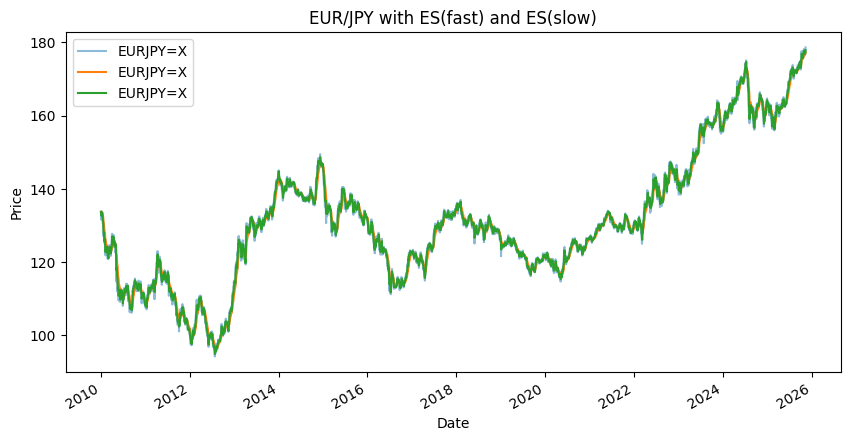

,alpha_long,beta_long,alpha_short,beta_short,x_abs,x_pct,slow_slope_thr,sharpe,win_rate,max_dd,avg_trade,num_trades
0,0.12,0.46,None,None,0.10,0.0,0.00,0.789255,58.8%,-2.669006,1.762444,17
1,0.12,0.46,None,None,0.10,0.0,0.01,0.771823,52.6%,-2.669006,1.563503,19
2,0.12,0.42,None,None,0.10,0.0,0.00,0.765059,57.1%,-3.278996,1.911683,14
3,0.12,0.44,None,None,0.10,0.0,0.01,0.764499,50.0%,-2.551006,1.513142,18
4,0.12,0.44,None,None,0.10,0.0,0.00,0.763176,53.3%,-3.281006,1.784103,15
5,0.12,0.46,None,None,0.10,0.0,0.02,0.747444,47.6%,-2.902011,1.378978,21
6,0.30,0.46,None,None,0.02,0.0,0.01,0.734655,66.7%,-1.874996,2.001779,9
7,0.12,0.42,None,None,0.10,0.0,0.02,0.724898,47.8%,-2.351010,1.214285,23
8,0.12,0.42,None,None,0.10,0.0,0.01,0.721869,44.4%,-3.414993,1.438031,18
9,0.12,0.46,None,None,0.10,0.0,0.04,0.721431,44.4%,-1.958997,1.090168,27


In [9]:

# ---------- Plots ----------
fig, ax = plt.subplots(figsize=(10,5))
best["equity"].plot(ax=ax)
ax.set_title("Equity Curve (EUR/JPY ES Strategy)")
ax.set_xlabel("Date"); ax.set_ylabel("Cumulative PnL (price units)")
plt.show()

# Overlay ES for the best (rebuild to plot)
aL, bL, aS, bS, xabs, xpct, slope_thr = best["grid"]
es_fast = exp_smooth(prices["price"], aL)
es_slow = exp_smooth(prices["price"], bL)

fig, ax = plt.subplots(figsize=(10,5))
prices["price"].plot(ax=ax, alpha=0.5, label="Price")
es_fast.plot(ax=ax, label=f"ES(fast α={aL})")
es_slow.plot(ax=ax, label=f"ES(slow β={bL})")
ax.legend()
ax.set_title("EUR/JPY with ES(fast) and ES(slow)")
ax.set_xlabel("Date"); ax.set_ylabel("Price")
plt.show()

# Show a compact metrics table
summary = gs.head(10).copy()
summary["win_rate"] = (summary["win_rate"]*100).round(1).astype(str) + "%"
display(summary)

# ---------- Optional: Macro Extensions (template) ----------
# If you have monthly macro series (e.g., relative GDP growth, trade balance differentials),
# you can merge them and allow X_ABS / SLOW_SLOPE_THR or even alpha/beta to depend on macro regimes.
#
# Example template (commented):
#
# macro = pd.read_csv("macro_monthly.csv", parse_dates=["Date"]).set_index("Date")
# # Columns like: 'gdp_rel', 'tradebal_rel', 'bop_rel' (EUR minus JPY)
# macro = macro.resample('D').ffill()  # align to daily via forward-fill
# df = prices.join(macro, how="left").ffill()
#
# # Regime logic: increase buffer in high-stress regime
# stress = (df["gdp_rel"] < df["gdp_rel"].median()).astype(int)
# # Then inside backtest, make X_ABS or SLOW_SLOPE_THR functions of 'stress' at time t.
#
# (Implementing this fully is dataset-specific and left as an extension.)
